In [1]:
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import OneHotEncoder as onehot
from sklearn import linear_model
from sklearn.cluster import KMeans
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.metrics import mean_absolute_percentage_error as mape
from statsmodels.tsa.stattools import pacf
import xgboost as xgb
from itertools import product
from scipy import signal
from scipy import stats
from statsmodels.tsa.deterministic import Fourier
from sklearn.model_selection import TimeSeriesSplit

In [ ]:
def spearman_corr_with_nan(x, y):
    # Handle categorical data if any
    if x.dtype.name == 'category':
        x = x.cat.codes
    if y.dtype.name == 'category':
        y = y.cat.codes

    # Filter out pairs with NaN in either column
    valid_indices = ~np.isnan(x) & ~np.isnan(y)

    # Calculate correlation if there are valid pairs
    if np.any(valid_indices):
        return spearmanr(x[valid_indices], y[valid_indices]).correlation
    else:
        return np.nan

In [12]:
def calculate_compounded_price(df, sort_column):
    df_sorted = df.sort_values(by=sort_column)
    compounded_price = df_sorted['TARGET'].cumsum()
    return df_sorted[sort_column], compounded_price

In [9]:
X_train = pd.read_csv('../challenge_data/X_train.csv')
Y_train = pd.read_csv('../challenge_data/Y_train.csv')
X_test = pd.read_csv('../challenge_data/X_test.csv')

In [10]:
X_train.head()

,ID,DAY_ID,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,FR_DE_EXCHANGE,DE_NET_EXPORT,FR_NET_EXPORT,DE_NET_IMPORT,...,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET
0,1054,206,FR,0.210099,-0.427458,-0.606523,0.606523,NaN,0.692860,NaN,...,-0.444661,-0.172680,-0.556356,-0.790823,-0.283160,-1.069070,-0.063404,0.339041,0.124552,-0.002445
1,2049,501,FR,-0.022399,-1.003452,-0.022063,0.022063,-0.573520,-1.130838,0.573520,...,-1.183194,-1.240300,-0.770457,1.522331,0.828412,0.437419,1.831241,-0.659091,0.047114,-0.490365
2,1924,687,FR,1.395035,1.978665,1.021305,-1.021305,-0.622021,-1.682587,0.622021,...,1.947273,-0.480700,-0.313338,0.431134,0.487608,0.684884,0.114836,0.535974,0.743338,0.204952
3,297,720,DE,-0.983324,-0.849198,-0.839586,0.839586,-0.270870,0.563230,0.270870,...,-0.976974,-1.114838,-0.507570,-0.499409,-0.236249,0.350938,-0.417514,0.911652,-0.296168,1.073948
4,1101,818,FR,0.143807,-0.617038,-0.924990,0.924990,NaN,0.990324,NaN,...,-0.526267,-0.541465,-0.424550,-1.088158,-1.011560,0.614338,0.729495,0.245109,1.526606,2.614378


In [11]:
############################################
### Split dataset for FR and DE
############################################
all_features=pd.merge(X_train, Y_train, on='ID', how='left')
quantatitve_data=all_features.drop('COUNTRY',axis=1)
df_fr = all_features[all_features['COUNTRY'] == 'FR'].drop('COUNTRY',axis=1)
df_de = all_features[all_features['COUNTRY'] == 'DE'].drop('COUNTRY',axis=1)

target_column = 'TARGET'
correlation_coeffs = df_fr.drop(target_column, axis=1).apply(lambda x: spearman_corr_with_nan(x, df_fr[target_column]))
print(correlation_coeffs)

ID                 -0.011895
DAY_ID             -0.009342
DE_CONSUMPTION     -0.051604
FR_CONSUMPTION     -0.020299
DE_FR_EXCHANGE     -0.015005
FR_DE_EXCHANGE      0.015005
DE_NET_EXPORT      -0.085175
FR_NET_EXPORT      -0.008333
DE_NET_IMPORT       0.085175
FR_NET_IMPORT       0.008333
DE_GAS              0.017550
FR_GAS             -0.031254
DE_COAL             0.018754
FR_COAL             0.068084
DE_HYDRO            0.087350
FR_HYDRO            0.071709
DE_NUCLEAR          0.010434
FR_NUCLEAR          0.004077
DE_SOLAR            0.038168
FR_SOLAR            0.007298
DE_WINDPOW         -0.080487
FR_WINDPOW         -0.121530
DE_LIGNITE          0.002197
DE_RESIDUAL_LOAD    0.053790
FR_RESIDUAL_LOAD    0.006008
DE_RAIN            -0.057378
FR_RAIN            -0.028452
DE_WIND            -0.038131
FR_WIND            -0.042187
DE_TEMP            -0.018114
FR_TEMP            -0.048669
GAS_RET             0.148956
COAL_RET            0.057616
CARBON_RET          0.191809
dtype: float64

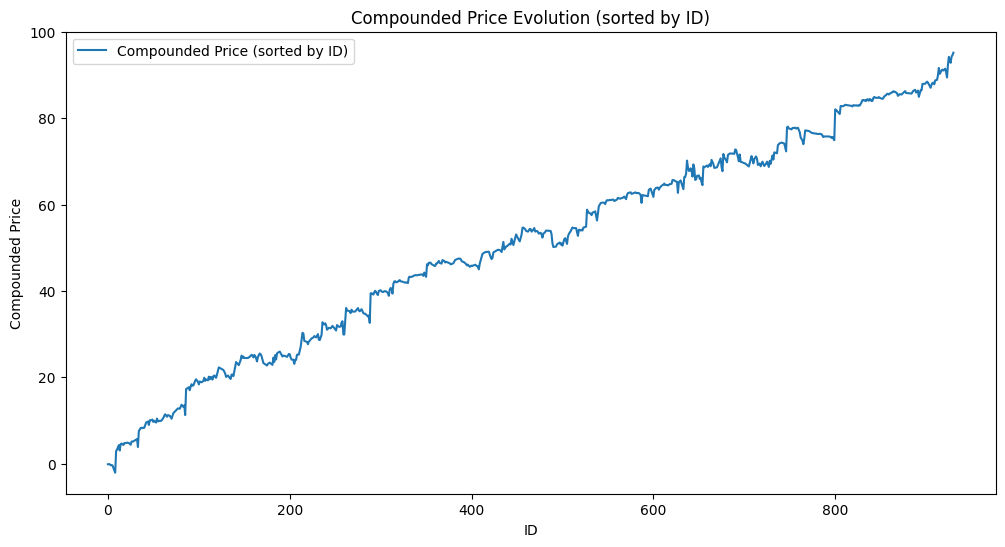

In [13]:
id_sorted, compounded_price_id = calculate_compounded_price(df_de, 'ID')
plt.figure(figsize=(12, 6))
plt.plot(id_sorted, compounded_price_id, label='Compounded Price (sorted by ID)')
plt.xlabel('ID')
plt.ylabel('Compounded Price')
plt.title('Compounded Price Evolution (sorted by ID)')
plt.legend()
plt.show()

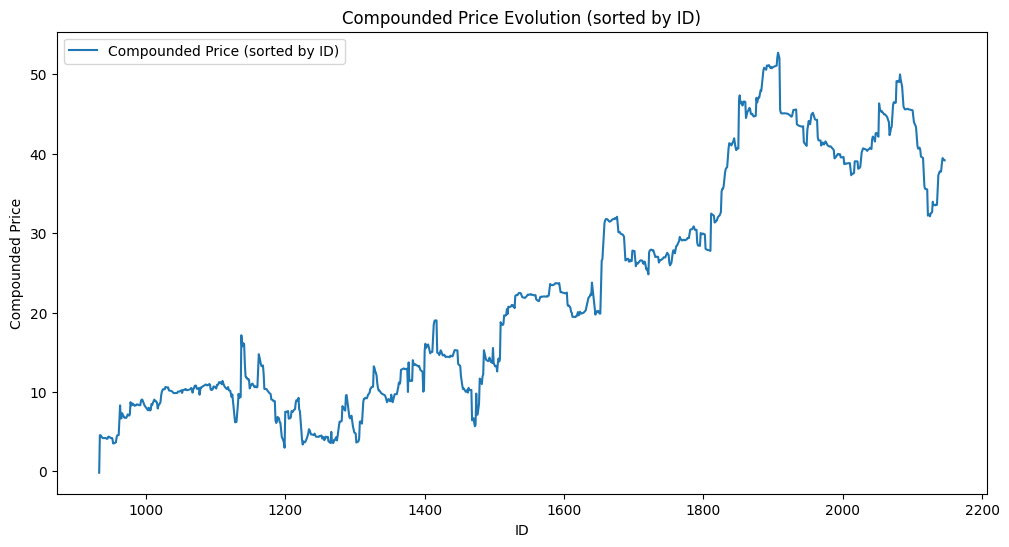

In [14]:
id_sorted, compounded_price_id = calculate_compounded_price(df_fr, 'ID')
plt.figure(figsize=(12, 6))
plt.plot(id_sorted, compounded_price_id, label='Compounded Price (sorted by ID)')
plt.xlabel('ID')
plt.ylabel('Compounded Price')
plt.title('Compounded Price Evolution (sorted by ID)')
plt.legend()
plt.show()

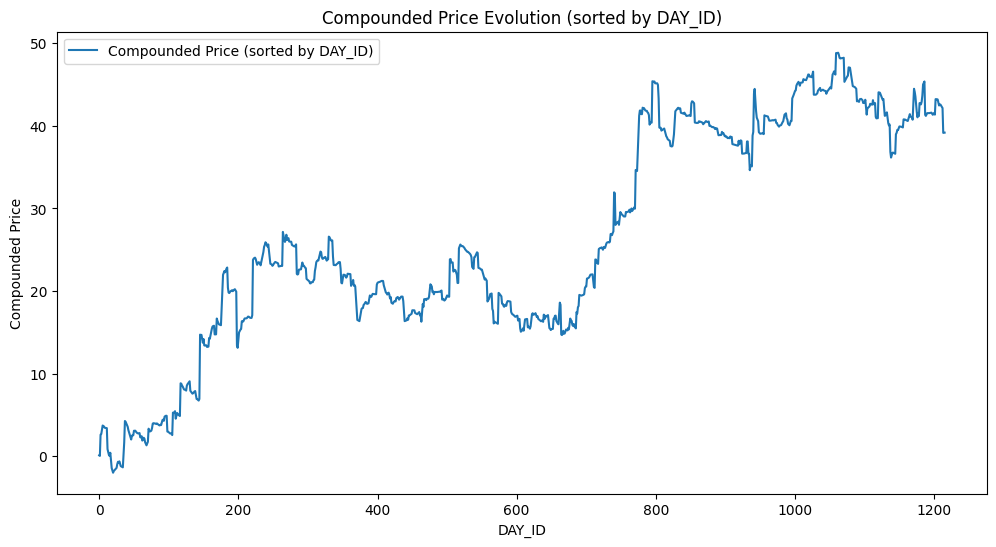

In [15]:
day_id_sorted, compounded_price_day_id = calculate_compounded_price(df_fr, 'DAY_ID')
plt.figure(figsize=(12, 6))
plt.plot(day_id_sorted, compounded_price_day_id, label='Compounded Price (sorted by DAY_ID)')
plt.xlabel('DAY_ID')
plt.ylabel('Compounded Price')
plt.title('Compounded Price Evolution (sorted by DAY_ID)')
plt.legend()
plt.show()

In [16]:
window_size = 365  #  can adjust later
df_fr['FR_TEMP_MA_BY_ID'] = df_fr.sort_values(by='ID')['FR_TEMP']
df_de['DE_TEMP_MA_BY_ID'] = df_de.sort_values(by='ID')['DE_TEMP'].rolling(window=window_size).mean()
df_fr['FR_TEMP_MA_BY_DAY_ID'] = df_fr.sort_values(by='DAY_ID')['FR_TEMP'].rolling(window=window_size).mean()
df_de['DE_TEMP_MA_BY_DAY_ID'] = df_de.sort_values(by='DAY_ID')['DE_TEMP'].rolling(window=window_size).mean()

In [18]:
# pd.set_option('display.max_columns', None)
# pd.set_option('display.max_columns', None)

# Load data and set 'ID' as the index
df = pd.read_csv('../challenge_data/X_train.csv').set_index('ID').sort_index()
y = pd.read_csv('../challenge_data/Y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('../challenge_data/X_test.csv').set_index('ID')

# Filter data for Germany and France
de = df[df['COUNTRY'] == 'DE']
y_de = y[y.index.isin(de.index)]  # Ensure the target dataframe (y) aligns with filtered data
fr = df[df['COUNTRY'] == 'FR']
y_fr = y[y.index.isin(fr.index)]  # Same as above for France

# Merging Training and Testing Data
# Ensure that both df and true_test are indeed DataFrames
if isinstance(df, pd.DataFrame) and isinstance(true_test, pd.DataFrame):
    full = pd.concat([df, true_test]).sort_index()
else:
    print("One of the objects is not a DataFrame.")

full_de = full[full['COUNTRY'] == 'DE']
full_fr = full[full['COUNTRY'] == 'FR']
# Data Normalization for Germany
full_de_norm = full_de.drop(['DAY_ID', 'COUNTRY'], axis=1)
full_de_norm = (full_de_norm - full_de_norm.mean()) / full_de_norm.std()
# Data Normalization for France
full_fr_norm = full_fr.drop(['DAY_ID', 'COUNTRY'], axis=1)
full_fr_norm = (full_fr_norm - full_fr_norm.mean()) / full_fr_norm.std()

In [20]:
# Train-Test Split
from sklearn.model_selection import train_test_split
bx_train, bx_test, by_train, by_test = train_test_split(df, y, test_size=0.33, random_state=88)
# Preparing Numeric Data
df_numeric = df.drop(['DAY_ID', 'COUNTRY', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1)
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))
# Identifying Weather Variables
weather_vars = ['DE_RAIN', 'DE_WIND', 'DE_TEMP', 'FR_RAIN', 'FR_WIND', 'FR_TEMP']
# Plotting Normalized Data
# for col in full_de_norm.columns:
#     plt.figure()
#     fig, ax = plt.subplots(figsize=(16, 6))
#     sns.lineplot(x=full_fr.index, y=full_fr[col])
#     plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
df = pd.read_csv('../challenge_data/X_train.csv').set_index('ID').sort_index()
y = pd.read_csv('../challenge_data/Y_train.csv').set_index('ID').sort_index()
true_test = pd.read_csv('../challenge_data/X_test.csv').set_index('ID')

# Combine training and test datasets
full = pd.concat([df, true_test]).sort_index()

# Choose a window size for the moving average
window_size = 80  # Example: 100-day moving average

# Calculate the moving average for temperature
full['DE_TEMP_MA'] = full['DE_TEMP'].rolling(window=window_size, min_periods=1).mean()
full['FR_TEMP_MA'] = full['FR_TEMP'].rolling(window=window_size, min_periods=1).mean()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(full.index, full['DE_TEMP_MA'], label='DE Temperature Moving Average')
plt.plot(full.index, full['FR_TEMP_MA'], label='FR Temperature Moving Average')
plt.xlabel('ID (Time)')
plt.ylabel('Temperature (Moving Average)')
plt.title('7-Day Moving Average of Temperature')
plt.legend()
plt.show()

<Figure size 1200x600 with 0 Axes>

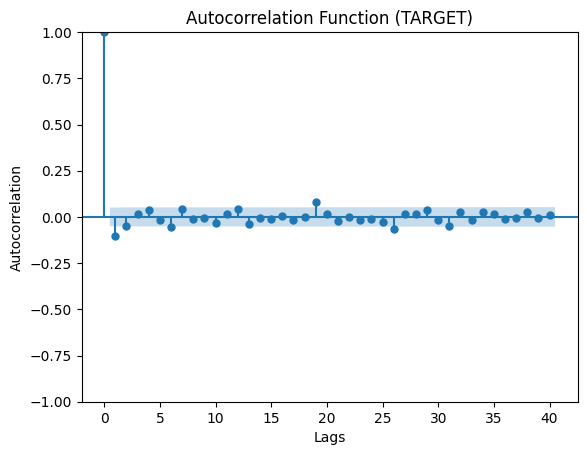

In [21]:
from statsmodels.graphics.tsaplots import plot_acf
aut = pd.read_csv('../challenge_data/Y_train.csv').set_index('ID').sort_index()
plt.figure(figsize=(12, 6))
plot_acf(aut['TARGET'], lags=40)  # You can adjust the number of lags
plt.title('Autocorrelation Function (TARGET)')
plt.xlabel('Lags')
plt.ylabel('Autocorrelation')
plt.show()

In [24]:
from statsmodels.tsa.stattools import acf
# Compute the autocorrelation values
autocorrelation_values = acf(aut['TARGET'], nlags=10, fft=True)  # Adjust 'nlags' as needed

# Print the autocorrelation values
for lag, value in enumerate(autocorrelation_values):
    print(f"Lag {lag}: {value}")

Lag 0: 1.0
Lag 1: -0.10479088680251424
Lag 2: -0.04710897306283744
Lag 3: 0.014607925710471157
Lag 4: 0.03722648827838236
Lag 5: -0.01746951678786256
Lag 6: -0.053384409116567944
Lag 7: 0.04134281627332301
Lag 8: -0.01355487544854191
Lag 9: -0.0057295405765432125
Lag 10: -0.031779348898386545


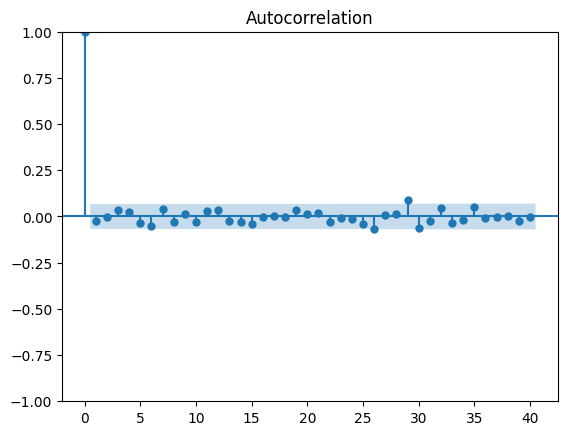

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(y_fr['TARGET'], model='additive', period=365)

# Plot the decomposition results
# decomposition.plot()
# plt.show()
# from scipy.signal import periodogram

# frequencies, spectrum = periodogram(y_fr['TARGET'], scaling='spectrum')

# plt.figure(figsize=(12, 6))
# plt.plot(frequencies, spectrum)
# plt.xlabel('Frequency')
# plt.ylabel('Spectral Density')
# plt.title('Periodogram for French Target Data')
# plt.show()

from statsmodels.graphics.tsaplots import plot_acf

# Adjust 'lags' based on your data and the suspected seasonal period
plot_acf(y_fr['TARGET'], lags=40)
plt.show()

In [2]:
import pandas as pd

# Load the datasets
df_train = pd.read_csv('../challenge_data/X_train.csv').set_index('ID').sort_index()
y_train = pd.read_csv('../challenge_data/Y_train.csv').set_index('ID').sort_index()
df_test = pd.read_csv('../challenge_data/X_test.csv').set_index('ID').sort_index()


de_train = df_train[df_train['COUNTRY'] == 'DE']
fr_train = df_train[df_train['COUNTRY'] == 'FR']

y_de_train = y_train[y_train.index.isin(de_train.index)]
y_fr_train = y_train[y_train.index.isin(fr_train.index)]

de_full = pd.concat([de_train, df_test[df_test['COUNTRY'] == 'DE']]).sort_index()
fr_full = pd.concat([fr_train, df_test[df_test['COUNTRY'] == 'FR']]).sort_index()

de_full.drop('COUNTRY', axis=1, inplace=True)
fr_full.drop('COUNTRY', axis=1, inplace=True)
de_full = de_full.join(de_full.shift(1), rsuffix='_prev_day')
fr_full = fr_full.join(fr_full.shift(1), rsuffix='_prev_day')

window_size = 50  # Example window size, can be adjusted
# Calculate moving averages for each column
for column in de_full.columns:
    if de_full[column].isnull().any():
        de_full[column+'_MA'] = de_full[column].rolling(window=window_size, min_periods=1).mean()
for column in de_full.columns:
    if '_MA' in column:
        original_column = column.replace('_MA', '')
        de_full[original_column].fillna(de_full[column], inplace=True)
        

for column in fr_full.columns:
    if fr_full[column].isnull().any():
        fr_full[column+'_MA'] = fr_full[column].rolling(window=window_size, min_periods=1).mean()
for column in fr_full.columns:
    if '_MA' in column:
        original_column = column.replace('_MA', '')
        fr_full[original_column].fillna(fr_full[column], inplace=True)

# Remove the moving average columns after filling missing values
de_full.drop([col for col in de_full.columns if '_MA' in col], axis=1, inplace=True)
fr_full.drop([col for col in fr_full.columns if '_MA' in col], axis=1, inplace=True)

de_test_final = de_full[de_full['DAY_ID'].isin(df_test[df_test['COUNTRY'] == 'DE']['DAY_ID'])]
fr_test_final = fr_full[fr_full['DAY_ID'].isin(df_test[df_test['COUNTRY'] == 'FR']['DAY_ID'])]
de_train_final = de_full[de_full['DAY_ID'].isin(df_train[df_train['COUNTRY'] == 'DE']['DAY_ID'])]
fr_train_final = fr_full[fr_full['DAY_ID'].isin(df_train[df_train['COUNTRY'] == 'FR']['DAY_ID'])]

In [3]:
columns_to_remove = [
    "DAY_ID", "FR_CONSUMPTION", "FR_DE_EXCHANGE", "FR_NET_EXPORT",
    "DE_NET_IMPORT", "FR_NET_IMPORT", "FR_GAS", "FR_COAL", "FR_HYDRO", 
    "FR_NUCLEAR", "FR_SOLAR", "FR_WINDPOW", "FR_RESIDUAL_LOAD", 
    "FR_RAIN", "FR_WIND", "FR_TEMP"
]
# Add columns with '_prev_day' suffix
columns_to_remove += [col + '_prev_day' for col in columns_to_remove]
# Remove the columns from de_train_final
de_train_final = de_train_final.drop(columns=columns_to_remove, errors='ignore')
de_train_final

,DE_CONSUMPTION,DE_FR_EXCHANGE,DE_NET_EXPORT,DE_GAS,DE_COAL,DE_HYDRO,DE_NUCLEAR,DE_SOLAR,DE_WINDPOW,DE_LIGNITE,...,DE_SOLAR_prev_day,DE_WINDPOW_prev_day,DE_LIGNITE_prev_day,DE_RESIDUAL_LOAD_prev_day,DE_RAIN_prev_day,DE_WIND_prev_day,DE_TEMP_prev_day,GAS_RET_prev_day,COAL_RET_prev_day,CARBON_RET_prev_day
ID,,,,,,,,,,,,,,,,,,,,,
0,0.583923,0.778353,0.931374,0.836731,0.200623,0.076310,0.780177,0.390828,-0.012385,0.625910,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.548187,-0.179177,0.588670,1.062806,0.292958,-0.487960,0.832773,0.447086,-0.329384,0.722983,...,0.500201,0.066511,0.790924,0.200128,-0.000759,-0.385935,-1.461775,-0.401694,0.718941,-2.161340
3,0.470907,-0.707035,0.111881,1.223117,0.150620,0.044238,0.842046,-0.053067,-0.446433,0.707787,...,0.447086,-0.329384,0.722983,0.529501,-0.274901,-0.248671,-1.817422,1.596267,1.409234,0.593396
4,0.284447,0.389806,1.506291,0.202693,-0.665840,-0.738709,0.126256,1.431625,0.465544,0.500184,...,-0.053067,-0.446433,0.707787,0.738900,-0.672022,-0.409482,-2.170678,0.172622,-0.847545,-0.313360
5,0.551274,0.226737,1.205343,0.637224,-0.746381,-0.014076,0.131863,1.377499,0.639742,0.247893,...,1.431625,0.465544,0.500184,-0.656051,-0.300883,-0.444411,-0.795390,-1.951199,0.273857,-1.847703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,1.032122,0.451691,0.437667,0.533996,0.568480,-0.473725,-1.914119,-1.120453,1.023247,0.347272,...,-0.898987,-0.075171,0.510573,0.869127,0.351382,0.635050,-1.170206,1.301767,0.987709,0.063759
927,0.979093,1.138619,0.480707,0.442421,0.785531,-1.121350,-1.919768,-0.636313,0.811159,0.436883,...,-1.120453,1.023247,0.347272,0.163624,-0.042241,1.506315,-1.225979,0.785530,-0.322581,0.362803
928,1.009837,-0.093751,-0.425785,0.796232,0.865687,-0.355897,-1.928200,-1.029400,0.292369,0.503896,...,-0.636313,0.811159,0.436883,0.160769,0.086420,1.007158,-0.107380,0.961630,0.891689,1.012246


In [4]:
print(de_train_final.shape)

(643, 34)


In [5]:
de_test_final = de_test_final.drop(columns=columns_to_remove, errors='ignore')
de_test_final

,DE_CONSUMPTION,DE_FR_EXCHANGE,DE_NET_EXPORT,DE_GAS,DE_COAL,DE_HYDRO,DE_NUCLEAR,DE_SOLAR,DE_WINDPOW,DE_LIGNITE,...,DE_SOLAR_prev_day,DE_WINDPOW_prev_day,DE_LIGNITE_prev_day,DE_RESIDUAL_LOAD_prev_day,DE_RAIN_prev_day,DE_WIND_prev_day,DE_TEMP_prev_day,GAS_RET_prev_day,COAL_RET_prev_day,CARBON_RET_prev_day
ID,,,,,,,,,,,,,,,,,,,,,
1,0.599993,0.141289,0.694028,0.959734,-0.096841,-0.602358,0.804110,0.500201,0.066511,0.790924,...,0.390828,-0.012385,0.625910,0.293219,-0.047033,-0.370706,-0.466573,1.602466,1.527066,1.790950
6,0.448365,-0.378787,0.972761,0.787415,-0.622520,-0.295697,0.109288,1.112920,0.494851,0.260600,...,1.377499,0.639742,0.247893,-0.613143,-0.347601,-0.530196,-0.511760,-0.307876,0.225957,-0.408372
7,0.094138,-0.526749,1.064523,-0.028746,-1.016151,-0.538727,0.019590,1.554578,0.855318,-0.539181,...,1.112920,0.494851,0.260600,-0.471106,-0.281556,-0.328795,0.250721,1.393826,0.542969,0.844307
11,0.176210,-1.192766,-1.878711,0.220693,-0.668626,1.735849,-0.531283,-0.104790,-0.097126,-0.658602,...,1.254850,0.182364,-0.941602,-0.365905,-0.122068,-0.502343,1.273429,0.175473,-0.139109,0.745399
16,0.504677,0.289817,0.013198,0.206821,-0.023925,0.998352,-0.536770,0.320655,0.199129,0.088074,...,0.128557,0.507406,-0.658681,-0.324858,0.176767,-0.031640,-0.872475,1.856983,0.649383,0.492941
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
904,-0.050292,-1.766032,-1.786085,1.828029,-0.425441,0.649499,-2.515970,-0.827586,-0.234243,-0.104233,...,-0.063056,1.144867,-0.557665,-0.677081,-0.363456,1.556915,-0.482770,0.136316,-0.222595,1.873843
911,-0.800945,0.302098,0.793661,-0.734524,-1.175361,-0.601500,-1.911091,-0.520532,1.494711,-1.220382,...,-0.396459,-0.464739,-0.243956,-0.178958,-0.110195,-0.122647,1.247977,-2.137522,-0.517327,-1.425136
916,0.562798,0.334508,0.152506,-0.038867,-0.555487,-0.515059,-1.870178,-0.213360,1.691505,-0.846478,...,-0.619042,1.884342,-1.057472,-1.155431,-0.480007,1.830272,0.645829,-2.465602,0.499851,-0.552975


In [6]:
de_test_final.shape

(289, 34)

In [7]:
columns_to_remove = [
    "DAY_ID", "DE_CONSUMPTION", "DE_FR_EXCHANGE", "DE_NET_EXPORT",
    "FR_NET_IMPORT", "DE_NET_IMPORT", "DE_GAS", "DE_COAL", "DE_HYDRO", 
    "DE_NUCLEAR", "DE_SOLAR", "DE_WINDPOW", "DE_RESIDUAL_LOAD", 
    "DE_RAIN", "DE_WIND", "DE_TEMP"
]
# Add columns with '_prev_day' suffix
columns_to_remove += [col + '_prev_day' for col in columns_to_remove]
# Remove the columns from de_train_final
fr_train_final = fr_train_final.drop(columns=columns_to_remove, errors='ignore')
fr_train_final

,FR_CONSUMPTION,FR_DE_EXCHANGE,FR_NET_EXPORT,FR_GAS,FR_COAL,FR_HYDRO,FR_NUCLEAR,FR_SOLAR,FR_WINDPOW,DE_LIGNITE,...,FR_SOLAR_prev_day,FR_WINDPOW_prev_day,DE_LIGNITE_prev_day,FR_RESIDUAL_LOAD_prev_day,FR_RAIN_prev_day,FR_WIND_prev_day,FR_TEMP_prev_day,GAS_RET_prev_day,COAL_RET_prev_day,CARBON_RET_prev_day
ID,,,,,,,,,,,,,,,,,,,,,
933,0.881603,NaN,NaN,-0.344762,-0.776396,0.554155,1.283956,-1.235034,2.436178,0.050227,...,-1.242489,2.739401,-0.887516,0.422827,1.183322,0.658659,1.533169,-0.509720,0.100740,-0.235452
934,0.813651,NaN,NaN,-0.097421,-0.778026,0.831906,1.386685,-1.100344,0.801223,0.296333,...,-1.235034,2.436178,0.050227,0.427023,2.127580,0.123975,1.835761,-0.355296,-0.301449,-0.220830
935,1.269656,NaN,NaN,0.726137,-0.121198,0.690618,1.557844,-1.179317,0.322378,1.091601,...,-1.100344,0.801223,0.296333,0.702082,0.967726,-0.608444,1.605309,0.317321,0.050629,-0.551201
936,1.391108,NaN,NaN,0.963235,0.327328,0.932772,1.760980,-1.054363,-0.158598,0.963711,...,-1.179317,0.322378,1.091601,1.264296,0.962364,-0.364924,0.456897,0.078996,-0.606772,0.270359
937,1.276328,NaN,NaN,1.116439,0.658796,0.756215,1.854408,-1.006239,-0.277055,1.369470,...,-1.054363,-0.158598,0.963711,1.486483,0.555446,-0.985396,-0.298126,-0.236740,0.616277,0.787153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,0.383270,-0.451691,-1.106814,1.097201,-0.216372,-0.883788,-1.489547,-0.213344,3.298833,0.347272,...,-0.938283,2.421032,0.510573,-0.173537,0.574014,1.630345,-0.395889,1.301767,0.987709,0.063759
2143,0.338229,-1.138619,-1.631364,0.367265,-0.234862,-0.696835,-1.418159,-0.304667,2.862619,0.436883,...,-0.213344,3.298833,0.347272,-0.322860,0.517631,2.584335,-0.113555,0.785530,-0.322581,0.362803
2144,0.237311,0.093751,-1.194162,0.675199,-0.222342,-0.714343,-1.331032,-0.211453,2.213918,0.503896,...,-0.304667,2.862619,0.436883,-0.265981,0.643169,1.445712,-0.046727,0.961630,0.891689,1.012246


In [8]:
fr_train_final.shape

(851, 34)

In [9]:
fr_test_final = fr_test_final.drop(columns=columns_to_remove, errors='ignore')
fr_test_final

,FR_CONSUMPTION,FR_DE_EXCHANGE,FR_NET_EXPORT,FR_GAS,FR_COAL,FR_HYDRO,FR_NUCLEAR,FR_SOLAR,FR_WINDPOW,DE_LIGNITE,...,FR_SOLAR_prev_day,FR_WINDPOW_prev_day,DE_LIGNITE_prev_day,FR_RESIDUAL_LOAD_prev_day,FR_RAIN_prev_day,FR_WIND_prev_day,FR_TEMP_prev_day,GAS_RET_prev_day,COAL_RET_prev_day,CARBON_RET_prev_day
ID,,,,,,,,,,,,,,,,,,,,,
932,0.946786,NaN,NaN,-0.388614,-0.777920,0.090513,1.238111,-1.242489,2.739401,-0.887516,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
939,1.508218,NaN,NaN,1.285000,1.154614,0.992382,1.695485,-0.967741,-0.810292,1.233358,...,-0.983346,-0.703833,1.384592,1.590333,-0.170922,-0.851370,0.128882,-0.199062,-0.349016,-0.357618
941,0.939746,NaN,NaN,-0.134591,-0.778982,1.546772,1.548665,-0.646622,2.005165,0.380554,...,-1.183434,2.085412,0.399380,1.193379,1.141601,-0.298330,0.143271,-0.357743,-0.300298,-1.325776
943,1.246096,NaN,NaN,1.394445,-0.397363,2.429251,1.969639,-1.116617,-0.567542,1.257627,...,-1.307275,0.216100,0.867581,1.097148,0.932309,-0.067636,1.617986,0.000000,-0.914862,-0.175794
948,1.743110,NaN,NaN,1.185415,0.382473,2.453694,1.773084,-0.643895,0.158930,1.223688,...,-0.897197,0.391869,0.897521,1.506125,-0.121676,-0.830899,-0.296548,-1.484809,-0.042391,0.647896
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2120,-0.919210,1.766032,-0.277062,0.900363,-0.673381,-0.951773,-2.005052,-0.186028,1.522451,-0.104233,...,-0.010419,1.072545,-0.557665,-1.088226,2.980386,1.092031,1.782143,0.136316,-0.222595,1.873843
2127,-1.390917,-0.302098,0.411873,-0.043101,-0.770846,-1.839570,-2.173160,0.584948,3.145141,-1.220382,...,0.133395,1.518863,-0.243956,-1.552772,-0.033065,1.587512,1.571404,-2.137522,-0.517327,-1.425136
2132,-0.416069,-0.334508,-0.553110,0.471768,-0.750863,-1.464502,-1.752755,-0.422723,3.505037,-0.846478,...,0.672488,2.867031,-1.057472,-1.126873,-0.393929,1.422180,0.788907,-2.465602,0.499851,-0.552975


In [10]:
from sklearn.model_selection import train_test_split
de_train_final.fillna(method='ffill', inplace=True)  # Forward fill
de_train_final.fillna(method='bfill', inplace=True)  # Backward fill
de_test_final.fillna(method='ffill', inplace=True)
de_test_final.fillna(method='bfill', inplace=True)
de_train_final

D:\Temp\ipykernel_20240\2483214851.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  de_train_final.fillna(method='ffill', inplace=True)  # Forward fill
D:\Temp\ipykernel_20240\2483214851.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  de_train_final.fillna(method='bfill', inplace=True)  # Backward fill
D:\Temp\ipykernel_20240\2483214851.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  de_test_final.fillna(method='ffill', inplace=True)
D:\Temp\ipykernel_20240\2483214851.py:5: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  de_test_final.fillna(method='bfill', inplace=True)


,DE_CONSUMPTION,DE_FR_EXCHANGE,DE_NET_EXPORT,DE_GAS,DE_COAL,DE_HYDRO,DE_NUCLEAR,DE_SOLAR,DE_WINDPOW,DE_LIGNITE,...,DE_SOLAR_prev_day,DE_WINDPOW_prev_day,DE_LIGNITE_prev_day,DE_RESIDUAL_LOAD_prev_day,DE_RAIN_prev_day,DE_WIND_prev_day,DE_TEMP_prev_day,GAS_RET_prev_day,COAL_RET_prev_day,CARBON_RET_prev_day
ID,,,,,,,,,,,,,,,,,,,,,
0,0.583923,0.778353,0.931374,0.836731,0.200623,0.076310,0.780177,0.390828,-0.012385,0.625910,...,0.500201,0.066511,0.790924,0.200128,-0.000759,-0.385935,-1.461775,-0.401694,0.718941,-2.161340
2,0.548187,-0.179177,0.588670,1.062806,0.292958,-0.487960,0.832773,0.447086,-0.329384,0.722983,...,0.500201,0.066511,0.790924,0.200128,-0.000759,-0.385935,-1.461775,-0.401694,0.718941,-2.161340
3,0.470907,-0.707035,0.111881,1.223117,0.150620,0.044238,0.842046,-0.053067,-0.446433,0.707787,...,0.447086,-0.329384,0.722983,0.529501,-0.274901,-0.248671,-1.817422,1.596267,1.409234,0.593396
4,0.284447,0.389806,1.506291,0.202693,-0.665840,-0.738709,0.126256,1.431625,0.465544,0.500184,...,-0.053067,-0.446433,0.707787,0.738900,-0.672022,-0.409482,-2.170678,0.172622,-0.847545,-0.313360
5,0.551274,0.226737,1.205343,0.637224,-0.746381,-0.014076,0.131863,1.377499,0.639742,0.247893,...,1.431625,0.465544,0.500184,-0.656051,-0.300883,-0.444411,-0.795390,-1.951199,0.273857,-1.847703
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
926,1.032122,0.451691,0.437667,0.533996,0.568480,-0.473725,-1.914119,-1.120453,1.023247,0.347272,...,-0.898987,-0.075171,0.510573,0.869127,0.351382,0.635050,-1.170206,1.301767,0.987709,0.063759
927,0.979093,1.138619,0.480707,0.442421,0.785531,-1.121350,-1.919768,-0.636313,0.811159,0.436883,...,-1.120453,1.023247,0.347272,0.163624,-0.042241,1.506315,-1.225979,0.785530,-0.322581,0.362803
928,1.009837,-0.093751,-0.425785,0.796232,0.865687,-0.355897,-1.928200,-1.029400,0.292369,0.503896,...,-0.636313,0.811159,0.436883,0.160769,0.086420,1.007158,-0.107380,0.961630,0.891689,1.012246


In [11]:
fr_train_final.fillna(method='ffill', inplace=True)
fr_train_final.fillna(method='bfill', inplace=True)
fr_test_final.fillna(method='ffill', inplace=True)
fr_test_final.fillna(method='bfill', inplace=True)
fr_train_final

D:\Temp\ipykernel_20240\3553727585.py:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fr_train_final.fillna(method='ffill', inplace=True)
D:\Temp\ipykernel_20240\3553727585.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fr_train_final.fillna(method='bfill', inplace=True)
D:\Temp\ipykernel_20240\3553727585.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fr_test_final.fillna(method='ffill', inplace=True)
D:\Temp\ipykernel_20240\3553727585.py:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  fr_test_final.fillna(method='bfill', inplace=True)


,FR_CONSUMPTION,FR_DE_EXCHANGE,FR_NET_EXPORT,FR_GAS,FR_COAL,FR_HYDRO,FR_NUCLEAR,FR_SOLAR,FR_WINDPOW,DE_LIGNITE,...,FR_SOLAR_prev_day,FR_WINDPOW_prev_day,DE_LIGNITE_prev_day,FR_RESIDUAL_LOAD_prev_day,FR_RAIN_prev_day,FR_WIND_prev_day,FR_TEMP_prev_day,GAS_RET_prev_day,COAL_RET_prev_day,CARBON_RET_prev_day
ID,,,,,,,,,,,,,,,,,,,,,
933,0.881603,0.349442,1.336866,-0.344762,-0.776396,0.554155,1.283956,-1.235034,2.436178,0.050227,...,-1.242489,2.739401,-0.887516,0.422827,1.183322,0.658659,1.533169,-0.509720,0.100740,-0.235452
934,0.813651,0.349442,1.336866,-0.097421,-0.778026,0.831906,1.386685,-1.100344,0.801223,0.296333,...,-1.235034,2.436178,0.050227,0.427023,2.127580,0.123975,1.835761,-0.355296,-0.301449,-0.220830
935,1.269656,0.349442,1.336866,0.726137,-0.121198,0.690618,1.557844,-1.179317,0.322378,1.091601,...,-1.100344,0.801223,0.296333,0.702082,0.967726,-0.608444,1.605309,0.317321,0.050629,-0.551201
936,1.391108,0.349442,1.336866,0.963235,0.327328,0.932772,1.760980,-1.054363,-0.158598,0.963711,...,-1.179317,0.322378,1.091601,1.264296,0.962364,-0.364924,0.456897,0.078996,-0.606772,0.270359
937,1.276328,0.349442,1.336866,1.116439,0.658796,0.756215,1.854408,-1.006239,-0.277055,1.369470,...,-1.054363,-0.158598,0.963711,1.486483,0.555446,-0.985396,-0.298126,-0.236740,0.616277,0.787153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2142,0.383270,-0.451691,-1.106814,1.097201,-0.216372,-0.883788,-1.489547,-0.213344,3.298833,0.347272,...,-0.938283,2.421032,0.510573,-0.173537,0.574014,1.630345,-0.395889,1.301767,0.987709,0.063759
2143,0.338229,-1.138619,-1.631364,0.367265,-0.234862,-0.696835,-1.418159,-0.304667,2.862619,0.436883,...,-0.213344,3.298833,0.347272,-0.322860,0.517631,2.584335,-0.113555,0.785530,-0.322581,0.362803
2144,0.237311,0.093751,-1.194162,0.675199,-0.222342,-0.714343,-1.331032,-0.211453,2.213918,0.503896,...,-0.304667,2.862619,0.436883,-0.265981,0.643169,1.445712,-0.046727,0.961630,0.891689,1.012246


In [12]:
# Assuming 'TARGET' is your target variable
X = de_train_final
y = y_de_train

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

# Train the model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(x_test)

# Calculate Spearman Correlation
spearman_corr_lr = spearmanr(y_pred_lr, y_test).correlation
print(f"Spearman Correlation for Linear Regression: {spearman_corr_lr:.1%}")

Spearman Correlation for Linear Regression: 71.4%


In [13]:
de_train_pred = lr_model.predict(X)
de_train = de_train_final.reset_index()
de_train['TARGET'] = de_train_pred
de_train = de_train[['ID', 'TARGET']]

In [14]:
de_test = lr_model.predict(de_test_final)
de_test_pred = de_test_final.reset_index()
de_test_pred['TARGET'] = de_test
de_test_pred = de_test_pred[['ID', 'TARGET']]

In [15]:
# Assuming 'TARGET' is your target variable
X = fr_train_final
y = y_fr_train

# Split the data
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)
from sklearn.linear_model import LinearRegression
from scipy.stats import spearmanr

# Train the model
lr_model = LinearRegression()
lr_model.fit(x_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(x_test)

# Calculate Spearman Correlation
spearman_corr_lr = spearmanr(y_pred_lr, y_test).correlation
print(f"Spearman Correlation for Linear Regression: {spearman_corr_lr:.1%}")

Spearman Correlation for Linear Regression: 21.0%


In [16]:
fr_train_pred = lr_model.predict(X)
fr_result = fr_train_final.reset_index()
fr_result['TARGET'] = fr_train_pred
fr_result = fr_result[['ID', 'TARGET']]

In [17]:
fr_test = lr_model.predict(fr_test_final)
fr_test_pred = fr_test_final.reset_index()
fr_test_pred['TARGET'] = fr_test
fr_test_pred = fr_test_pred[['ID', 'TARGET']]

In [18]:
y_train = pd.read_csv('../challenge_data/Y_train.csv')
train_pred = pd.DataFrame()
train_pred['ID'] = y_train['ID']

train_pred = train_pred.merge(de_train[['ID', 'TARGET']], on='ID', how='left')
train_pred = train_pred.merge(fr_result[['ID', 'TARGET']], on='ID', how='left')

train_pred['TARGET'] = train_pred['TARGET_x'].combine_first(train_pred['TARGET_y'])

train_pred = train_pred.drop(['TARGET_x', 'TARGET_y'], axis=1)

spearman_corr_lr = spearmanr(train_pred['TARGET'], y_train['TARGET']).correlation
print(f"Spearman Correlation for Linear Regression: {spearman_corr_lr:.1%}")

Spearman Correlation for Linear Regression: 51.5%


In [19]:
train_pred.shape

(1494, 2)

In [20]:
train_pred.to_csv('./Train submission/ma_train.csv', index = False)

In [50]:
df_test = pd.read_csv('../challenge_data/X_test.csv')
test_pred = pd.DataFrame()
test_pred['ID'] = df_test['ID']
test_pred = test_pred.merge(de_test_pred[['ID', 'TARGET']], on='ID', how='left')
test_pred = test_pred.merge(fr_test_pred[['ID', 'TARGET']], on='ID', how='left')
test_pred['TARGET'] = test_pred['TARGET_x'].combine_first(test_pred['TARGET_y'])
test_pred = test_pred.drop(['TARGET_x', 'TARGET_y'], axis=1)

In [51]:
test_pred

,ID,TARGET
0,1115,0.047286
1,1202,0.020810
2,1194,0.246302
3,1084,0.280554
4,1135,0.132439
...,...,...
649,879,-0.906298
650,673,-0.620182
651,1641,0.302310
652,712,2.131317


In [52]:
test_pred.to_csv('./Submission/' + 'MA_final' + '.csv', index=False)